In [1]:
import os

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13188714620339487945
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6709723791
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15478892486590247042
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:08:00.0, compute capability: 6.1"
]


In [3]:
HEIGHT = 28 # Height of the image
WIDTH = 28 # Width of the image
CHANNELS = 1 # Number of channels for an image

Z_DIM = 100 # Dimensions of noise vector z
BATCH_SIZE = 128 # Batch size for training

D_LEARNING_RATE = 2e-4
G_LEARNING_RATE = 2e-4
N_EPOCHS = 300
BETA1 = 0.5
G_ITERS = 1
RUN_NAME = f"vanilla_NO_BN_d_lr{D_LEARNING_RATE}_g_lr{G_LEARNING_RATE}_{BETA1}_{G_ITERS}_{N_EPOCHS}"
SAVE_PATH = None

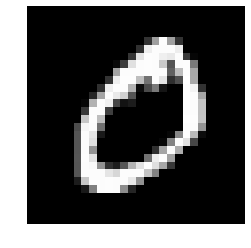

In [4]:
image_dir = 'C:\\Users\\Jonathan\\Documents\\development\\datasets\\images\\mnist\\training'
image_list = []
for directory in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']:
    for root, d, files in os.walk(os.path.join(image_dir, directory)):
        for file in files:
            if file.endswith('.png'):
                image_list.append(os.path.join(directory, file))

plt.imshow(cv2.imread(os.path.join(image_dir, image_list[0])))
plt.axis('off')
plt.show()

In [5]:
def make_grid(images, rows=8, cols=8):
    grid = np.zeros([images.shape[1] * rows, images.shape[2] * cols])
    
    if rows * cols > images.shape[0]:
        return
    
    i = 0
    for y in range(0, grid.shape[0], images.shape[1]):
        for x in range(0, grid.shape[1], images.shape[2]):
            grid[y:y+images.shape[1], x:x + images.shape[2]] = images[i]
            i += 1
    return grid

def plot_images(images, rows=8, cols=8):
    grid = make_grid(images, rows, cols)
    plt.figure(figsize=(12, 12))
    plt.imshow(grid, cmap='gray')
    plt.axis('off')
    plt.show()

In [6]:
image_list = image_list[:59904]
len(image_list) / BATCH_SIZE

468.0

In [7]:
g_layers = [256, HEIGHT * WIDTH]
d_layers = [256, 1]

def inverse_transform(image):
    return ((image + 1.) / 2.).clip(0, 1)

def transform(image):
    return ((image * 2. - 1.)).clip(-1, 1)

def generator(z, layers, training=True, reuse=False):
    with tf.variable_scope("generator", reuse=reuse) as scope:
        for i in range(len(layers) - 1):
            z = tf.layers.dense(z, layers[i], use_bias=True, name=f'g_h{i}')
            z = tf.nn.relu(z)
        
        z = tf.layers.dense(z, layers[-1], use_bias=True, name=f'g_h{len(layers) - 1}')
        z = tf.nn.tanh(z)
        return z
    
def discriminator(x, layers, training=True, reuse=False):
    with tf.variable_scope("discriminator", reuse=reuse) as scope:
        for i in range(len(layers) - 1):
            x = tf.layers.dense(x, layers[i], use_bias=True, name=f'd_h{i}')
            x = tf.nn.leaky_relu(x, alpha=0.2)
            
        x = tf.layers.dense(x, layers[-1], use_bias=True, name=f'd_h{len(layers) - 1}')
        return x

In [8]:
def inverse_transform(image):
    return ((image + 1.) / 2.).clip(0, 1)

def transform(image):
    return ((image * 2. - 1.)).clip(-1, 1)

def generator(z, layers, training=True, reuse=False):
    with tf.variable_scope("generator", reuse=reuse) as scope:
        for i in range(len(layers) - 1):
            z = tf.layers.dense(z, layers[i], use_bias=True, 
                                kernel_initializer=tf.initializer.truncated_normal(mean=0, stddev=0.02),
                                name=f'g_h{i}')
            z = tf.nn.relu(z)
        
        z = tf.layers.dense(z, layers[-1], use_bias=True, name=f'g_h{len(layers) - 1}')
        z = tf.nn.tanh(z)
        return z
    
def discriminator(x, layers, training=True, reuse=False):
    with tf.variable_scope("discriminator", reuse=reuse) as scope:
        for i in range(len(layers) - 1):
            x = tf.layers.dense(x, layers[i], use_bias=True, 
                                kernel_initializer=tf.initializer.truncated_normal(mean=0, stddev=0.02),
                                name=f'd_h{i}')
            x = tf.nn.leaky_relu(x, alpha=0.2)
            
        x = tf.layers.dense(x, layers[-1], use_bias=True, name=f'd_h{len(layers) - 1}')
        return x

[<tf.Variable 'discriminator/d_h0/kernel:0' shape=(784, 256) dtype=float32_ref>, <tf.Variable 'discriminator/d_h0/bias:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'discriminator/d_h1/kernel:0' shape=(256, 1) dtype=float32_ref>, <tf.Variable 'discriminator/d_h1/bias:0' shape=(1,) dtype=float32_ref>]
[<tf.Variable 'generator/g_h0/kernel:0' shape=(100, 256) dtype=float32_ref>, <tf.Variable 'generator/g_h0/bias:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'generator/g_h1/kernel:0' shape=(256, 784) dtype=float32_ref>, <tf.Variable 'generator/g_h1/bias:0' shape=(784,) dtype=float32_ref>]


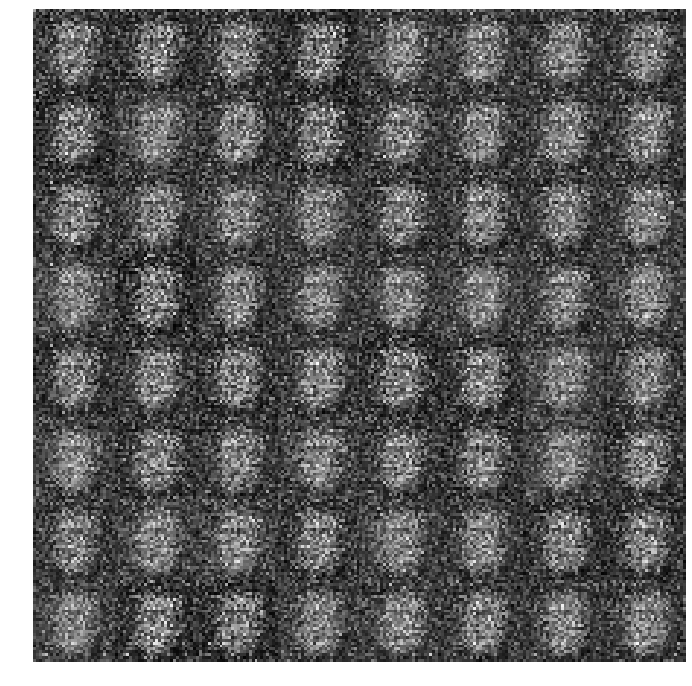

[Epoch 0/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 1/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 2/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 3/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 4/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


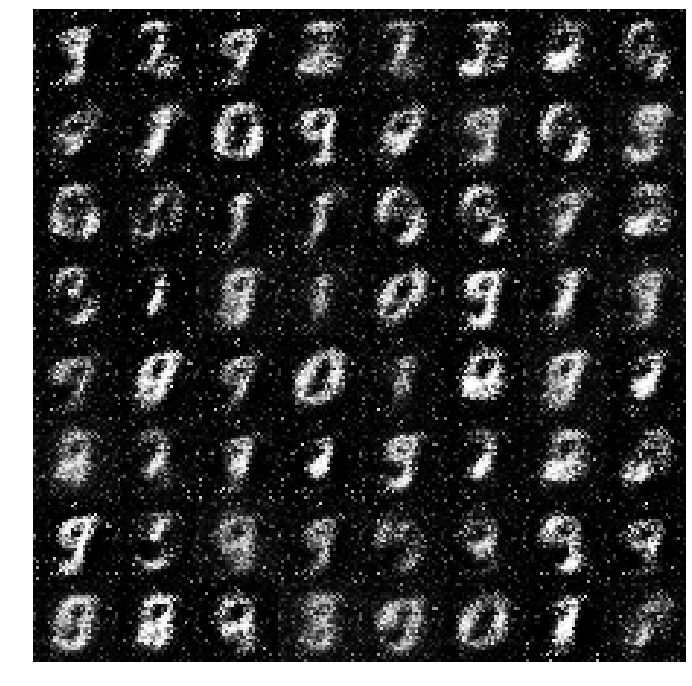

[Epoch 5/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 6/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 7/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 8/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 9/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


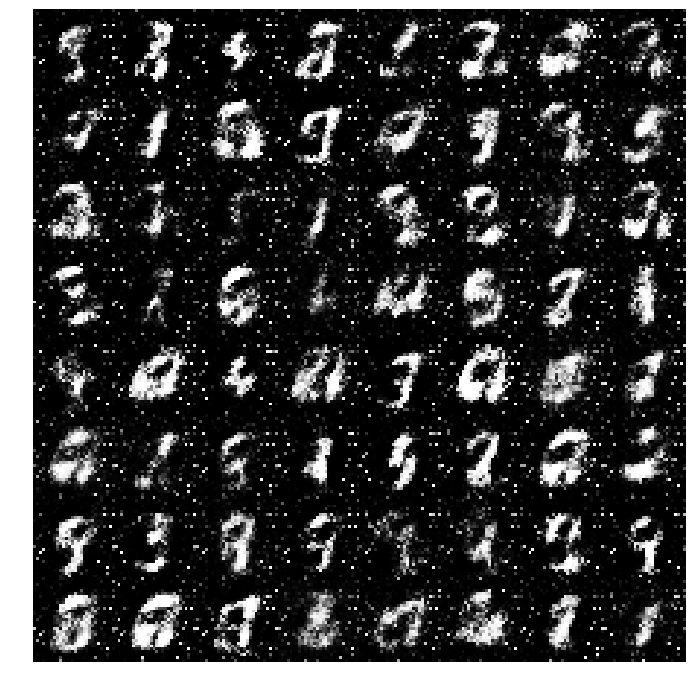

[Epoch 10/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 11/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 12/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 13/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 14/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


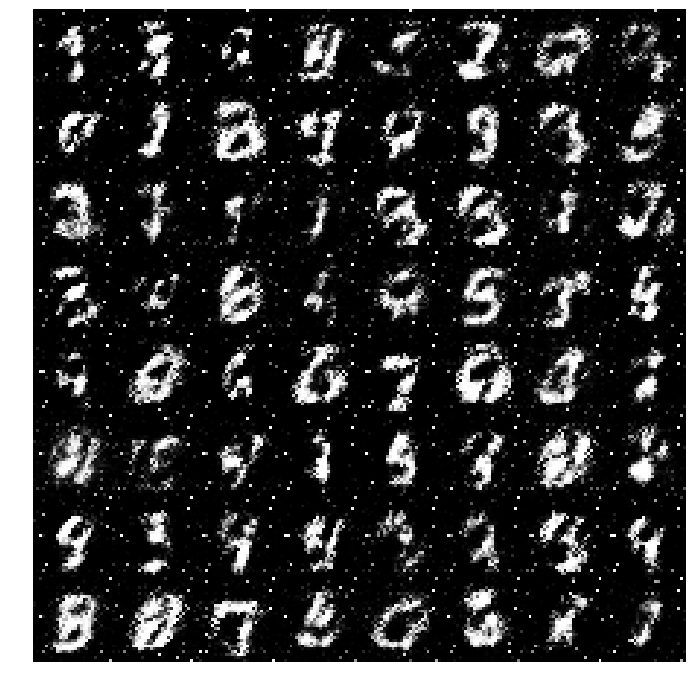

[Epoch 15/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 16/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 17/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 18/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 19/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


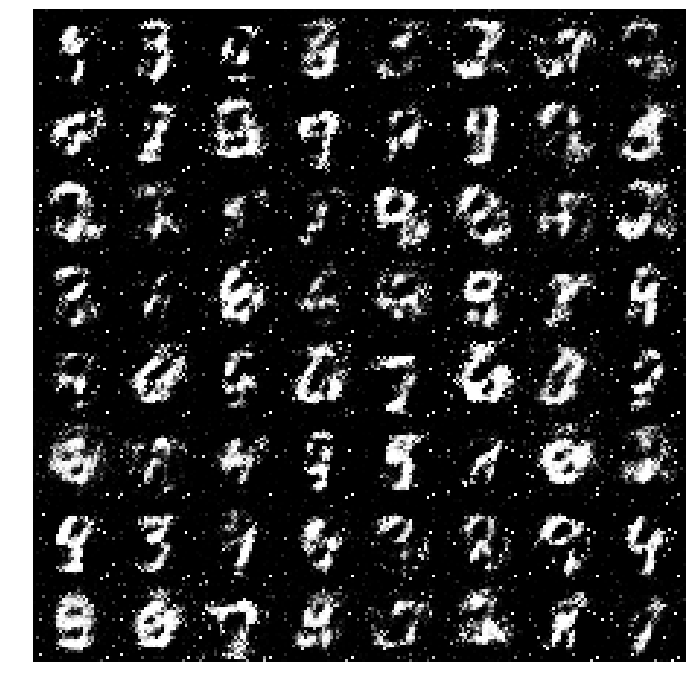

[Epoch 20/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 21/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 22/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 23/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 24/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


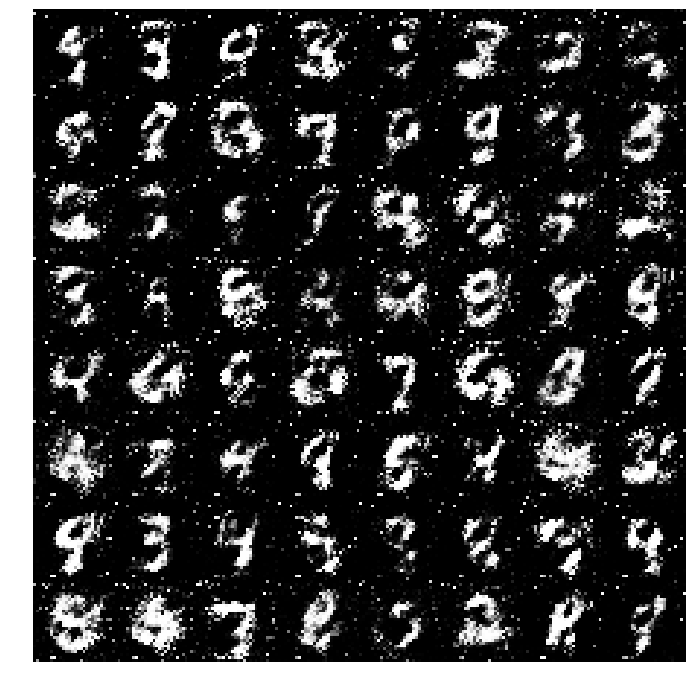

[Epoch 25/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 26/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 27/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 28/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 29/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


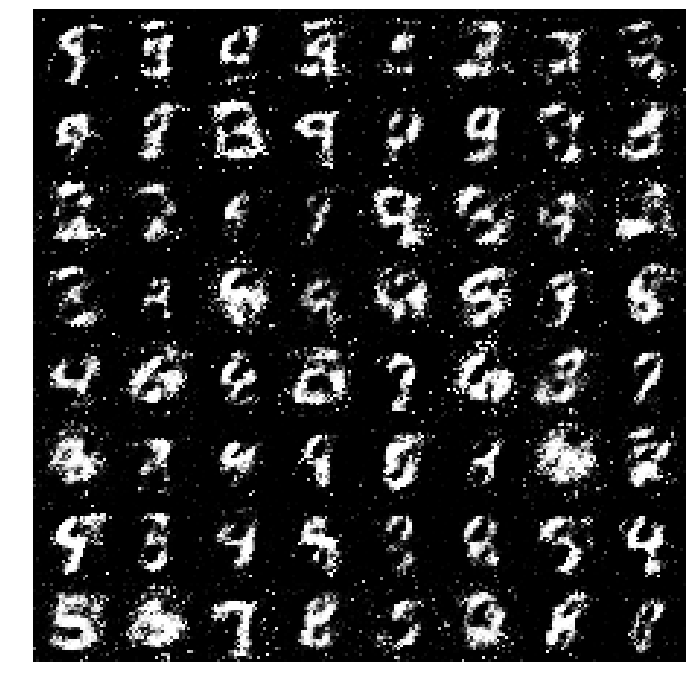

[Epoch 30/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 31/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 32/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 33/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 34/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


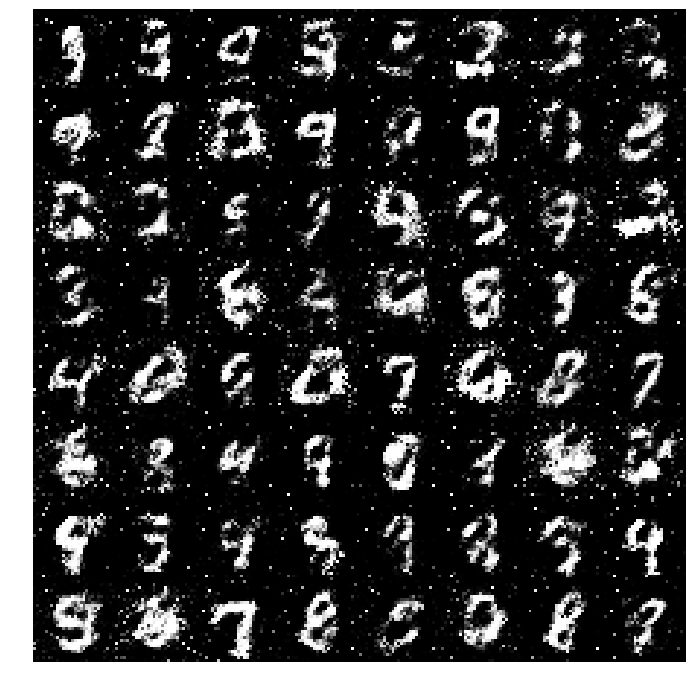

[Epoch 35/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 36/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 37/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 38/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 39/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


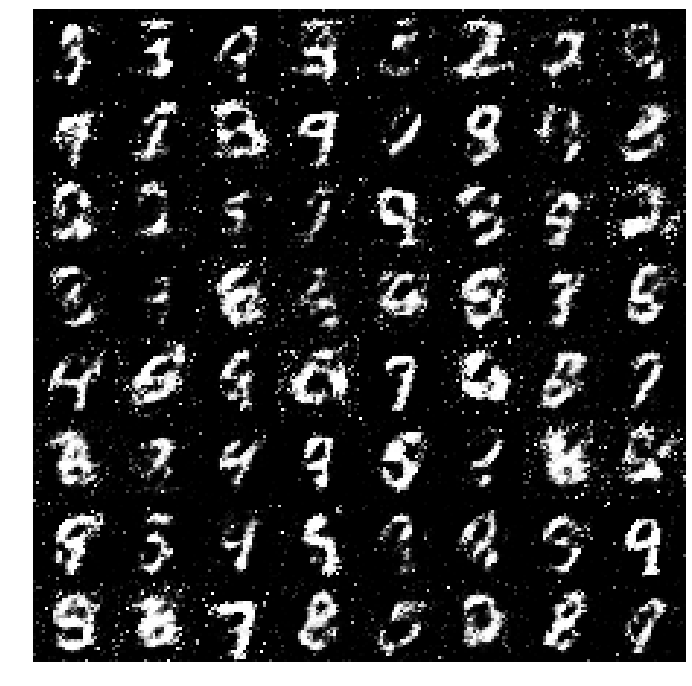

[Epoch 40/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 41/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 42/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 43/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 44/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


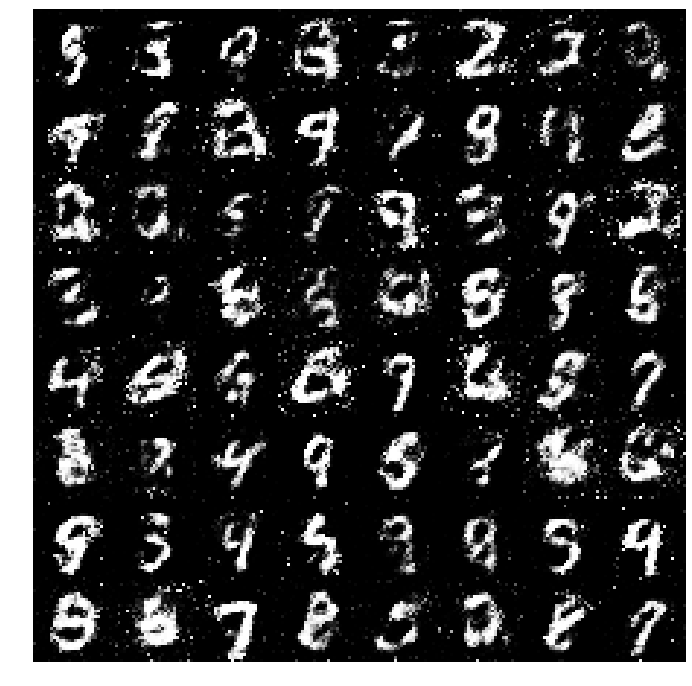

[Epoch 45/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 46/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 47/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 48/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 49/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


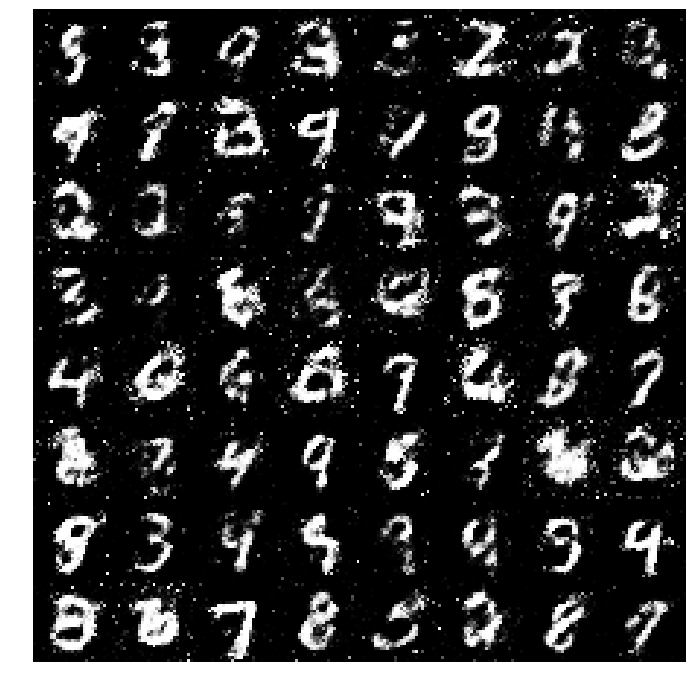

[Epoch 50/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 51/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 52/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 53/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 54/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


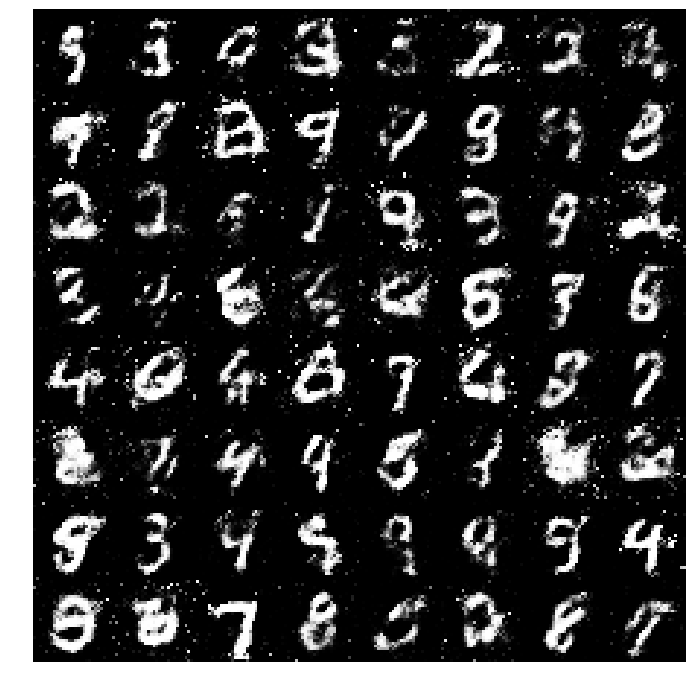

[Epoch 55/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 56/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 57/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 58/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 59/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


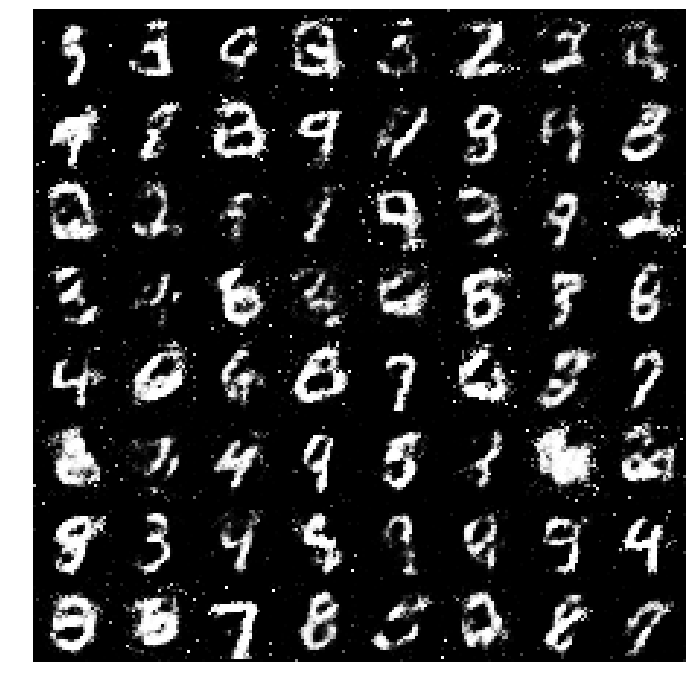

[Epoch 60/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 61/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 62/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 63/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 64/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


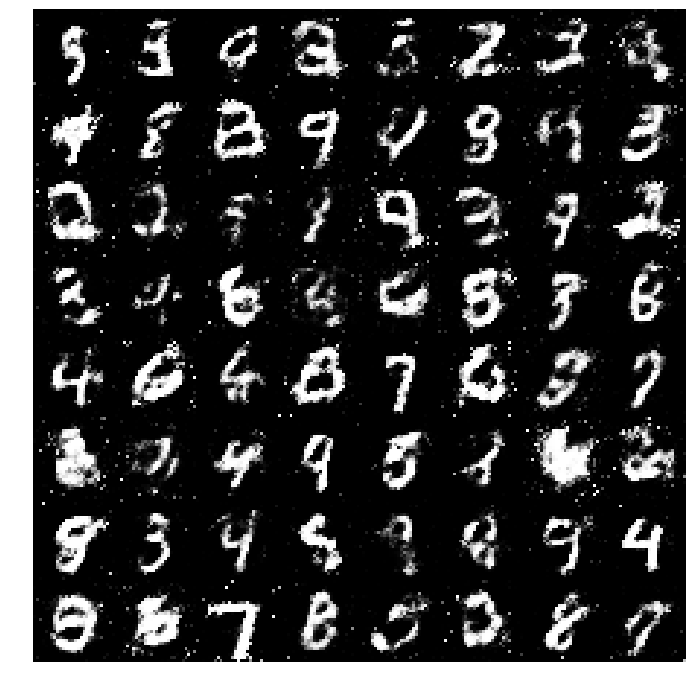

[Epoch 65/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 66/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 67/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 68/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 69/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


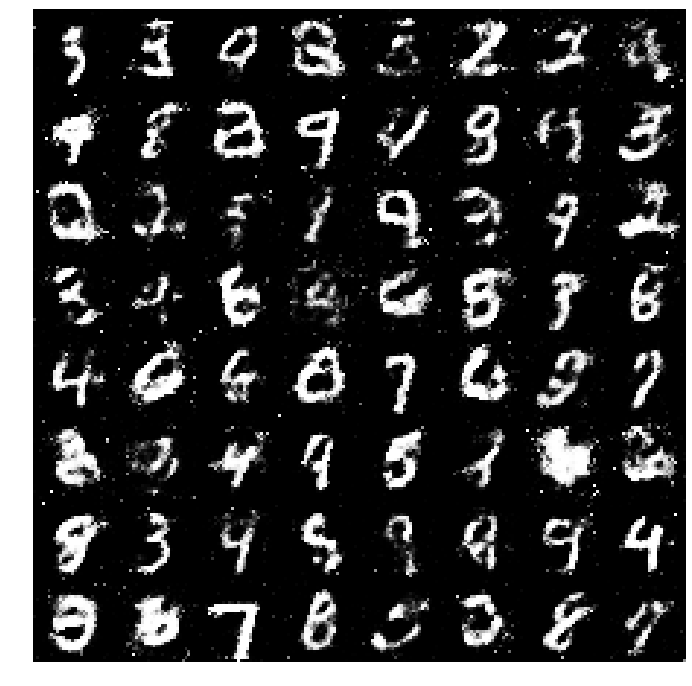

[Epoch 70/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 71/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 72/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 73/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 74/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


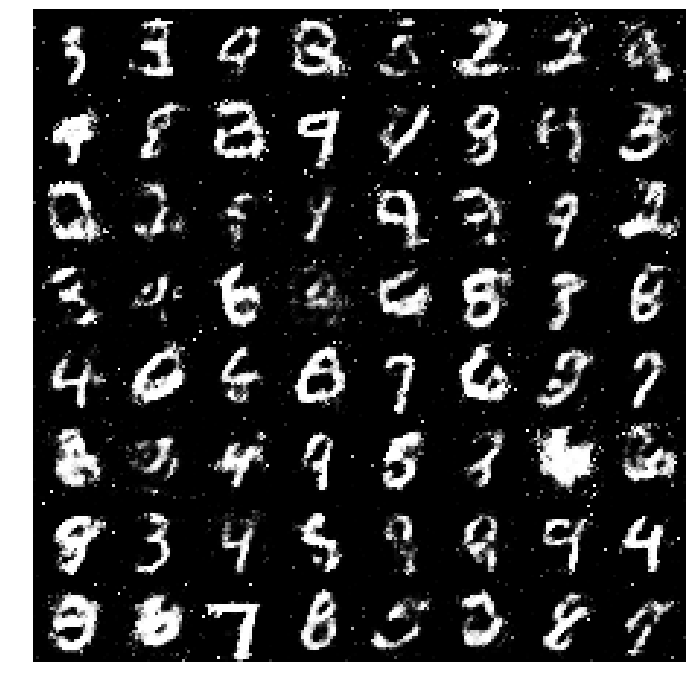

[Epoch 75/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 76/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 77/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 78/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 79/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


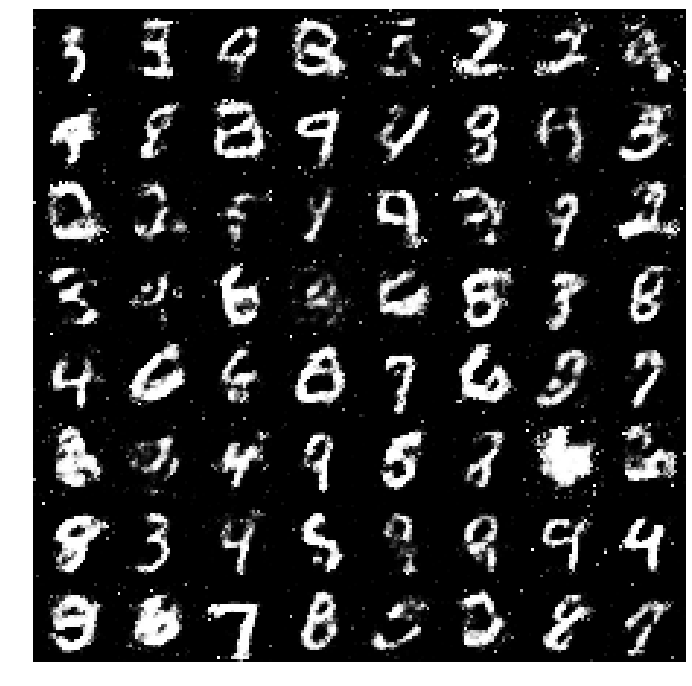

[Epoch 80/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 81/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 82/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 83/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 84/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


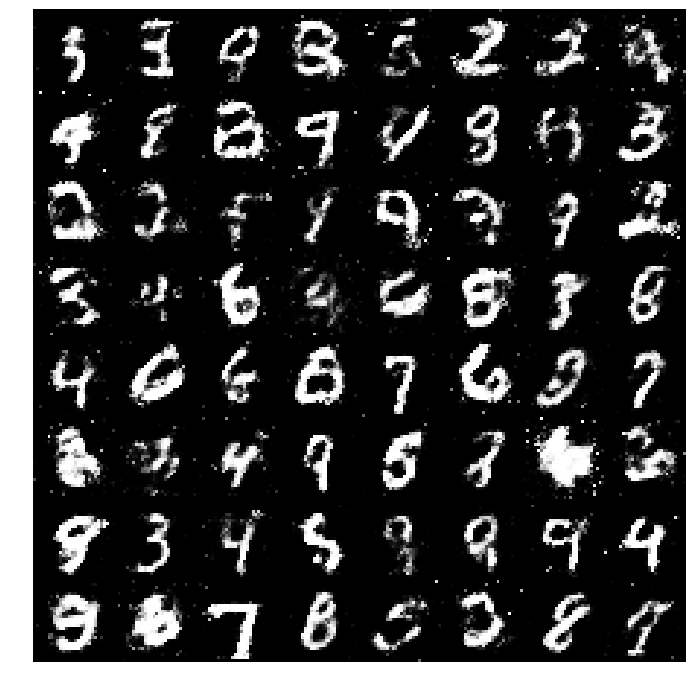

[Epoch 85/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 86/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 87/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 88/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 89/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


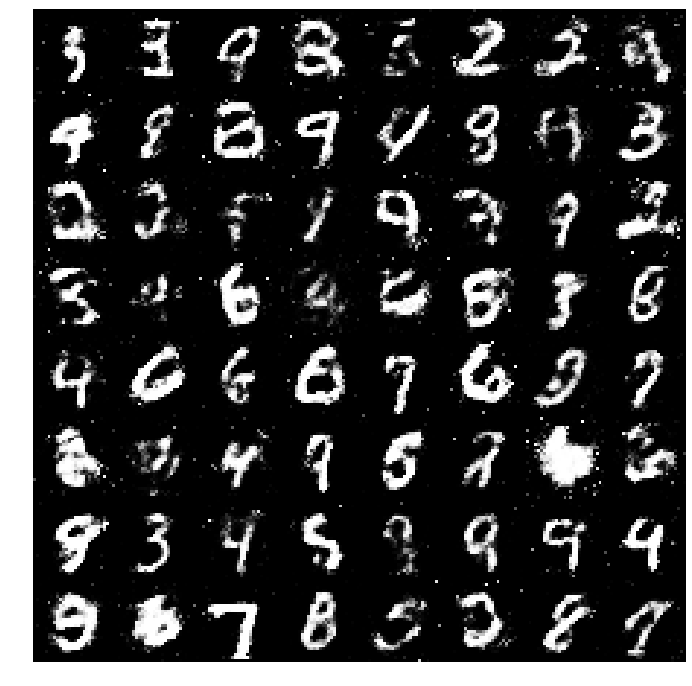

[Epoch 90/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 91/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 92/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 93/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 94/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


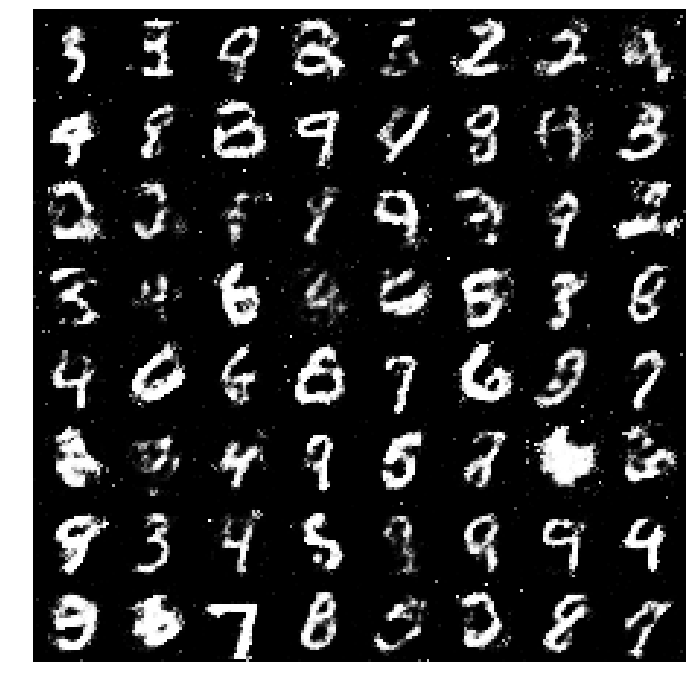

[Epoch 95/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 96/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 97/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 98/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 99/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


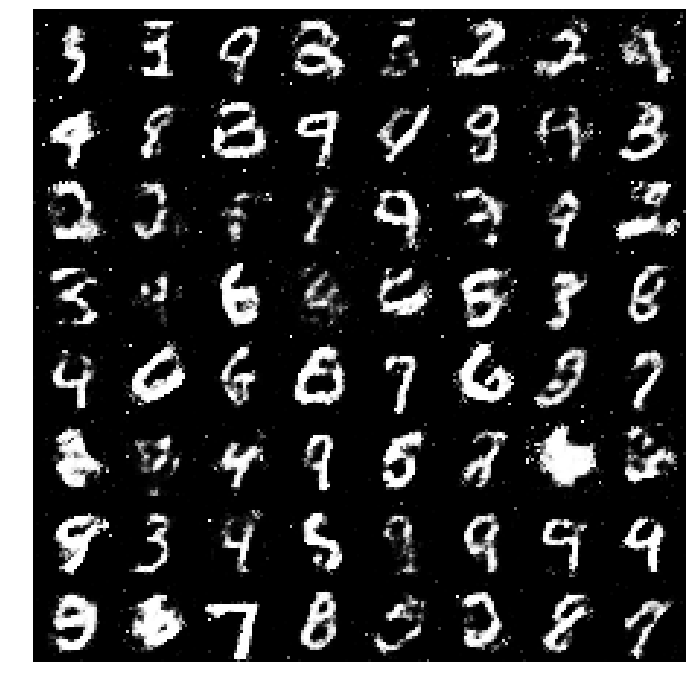

[Epoch 100/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 101/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 102/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 103/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 104/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


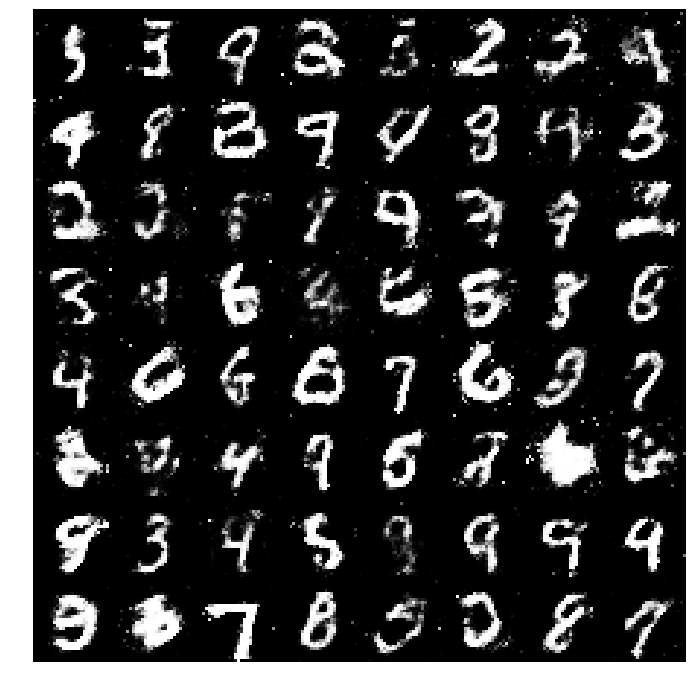

[Epoch 105/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 106/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 107/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 108/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 109/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


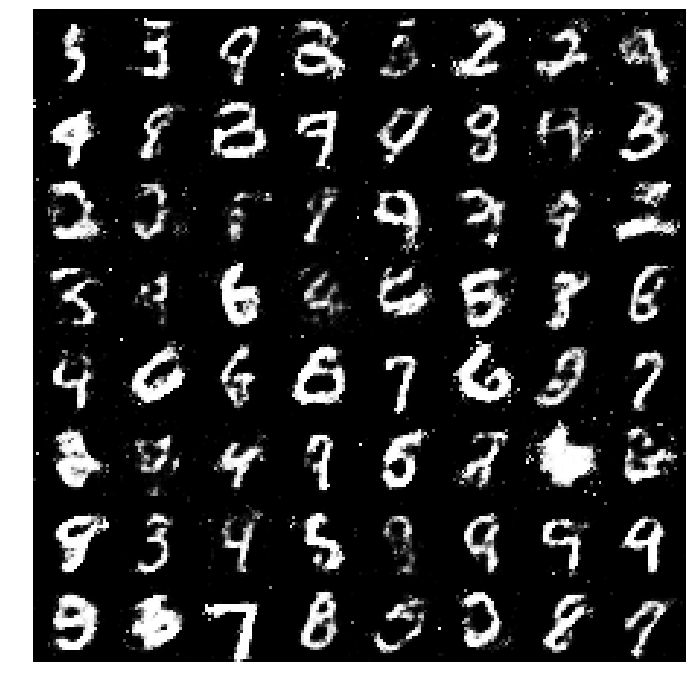

[Epoch 110/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 111/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 112/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 113/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 114/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


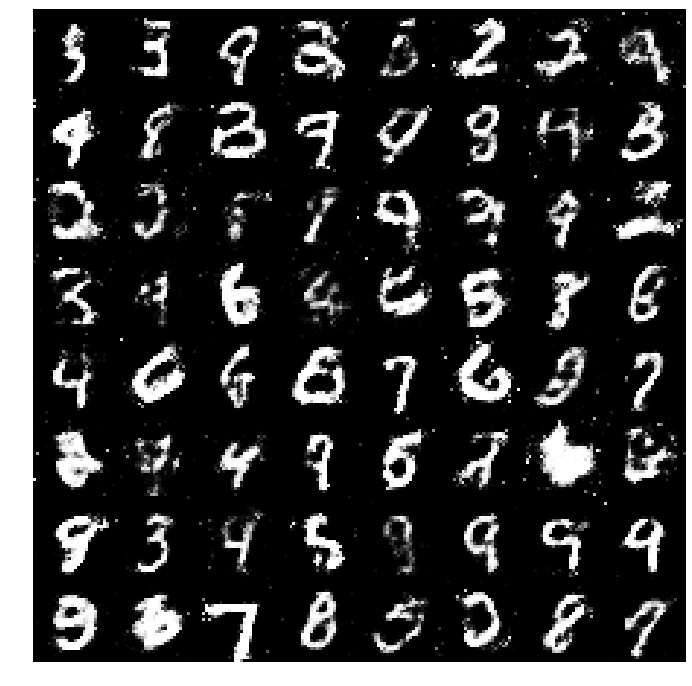

[Epoch 115/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 116/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 117/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 118/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 119/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


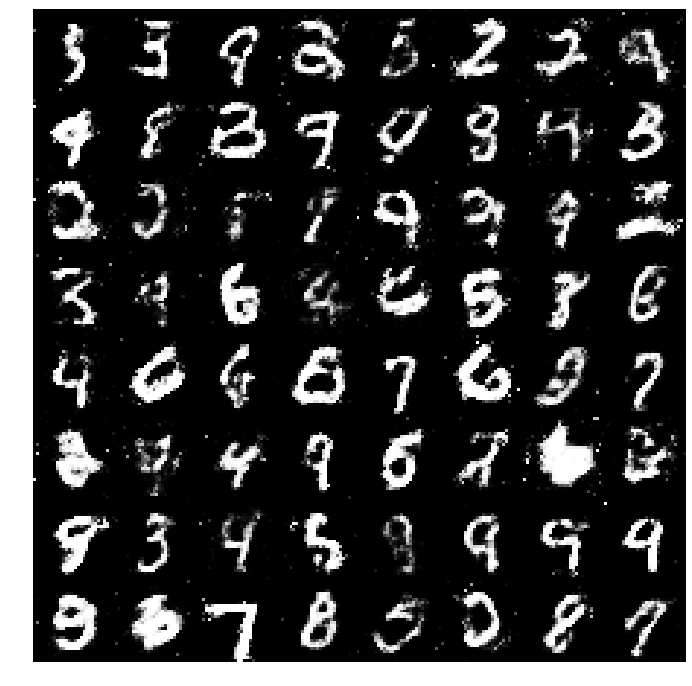

[Epoch 120/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 121/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 122/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 123/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 124/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


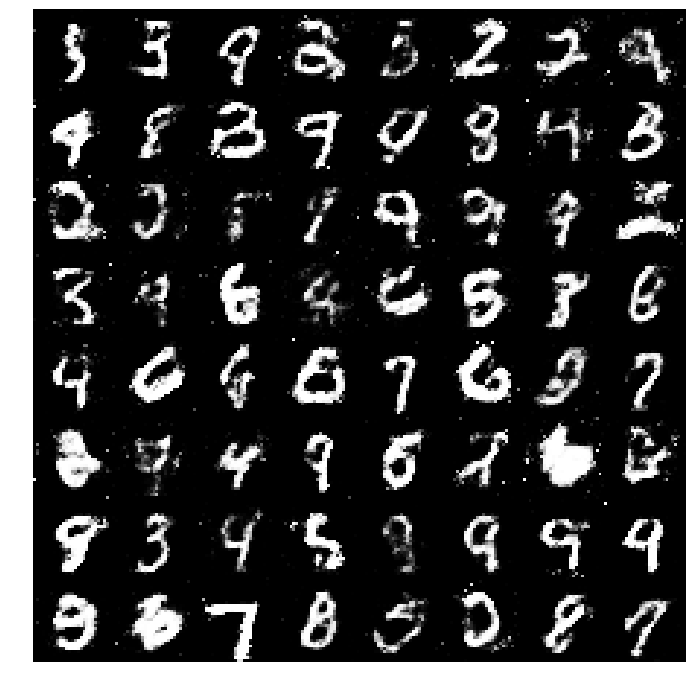

[Epoch 125/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 126/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 127/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 128/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 129/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


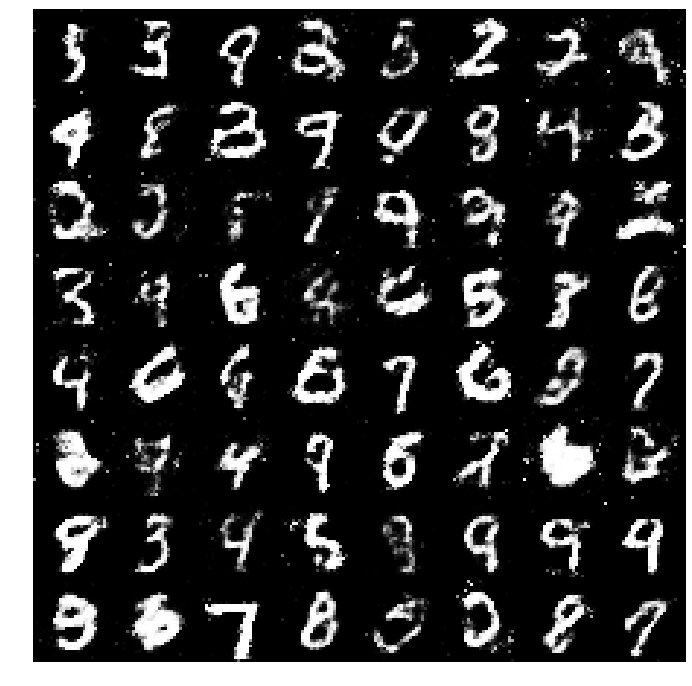

[Epoch 130/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 131/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 132/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 133/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 134/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


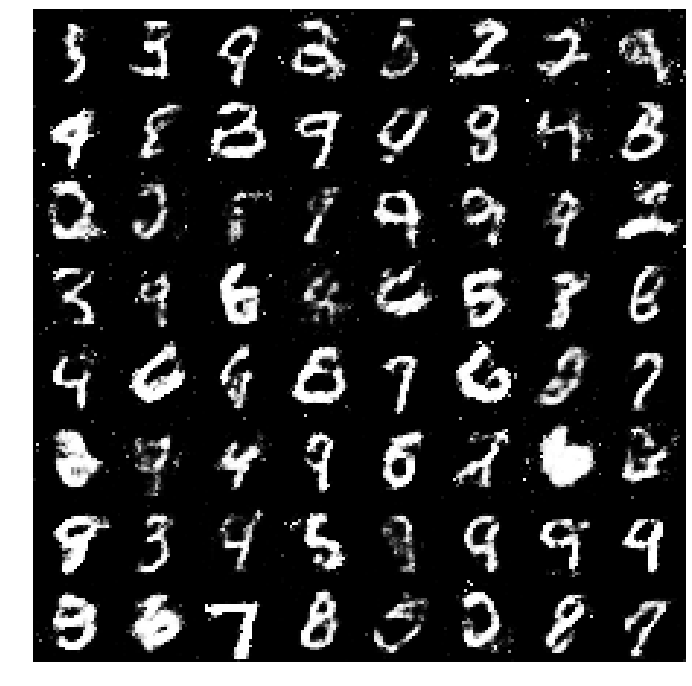

[Epoch 135/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 136/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 137/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 138/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 139/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


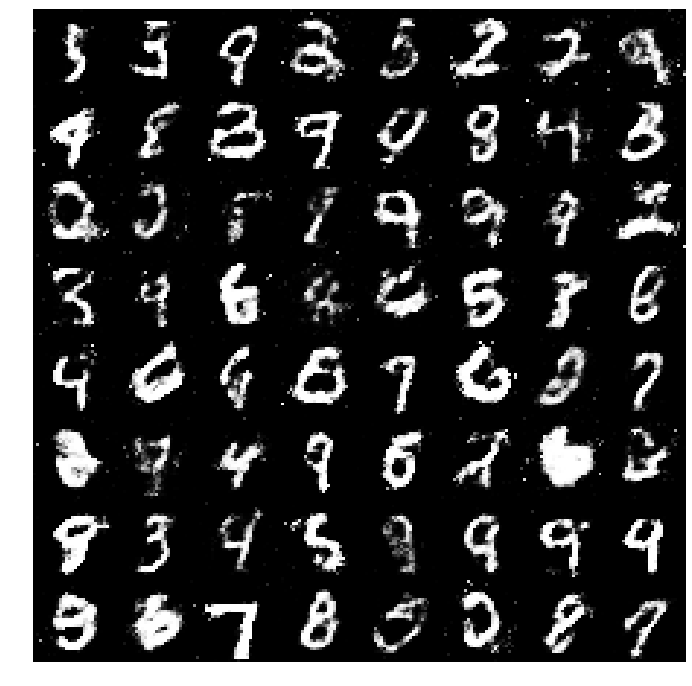

[Epoch 140/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 141/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 142/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 143/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 144/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


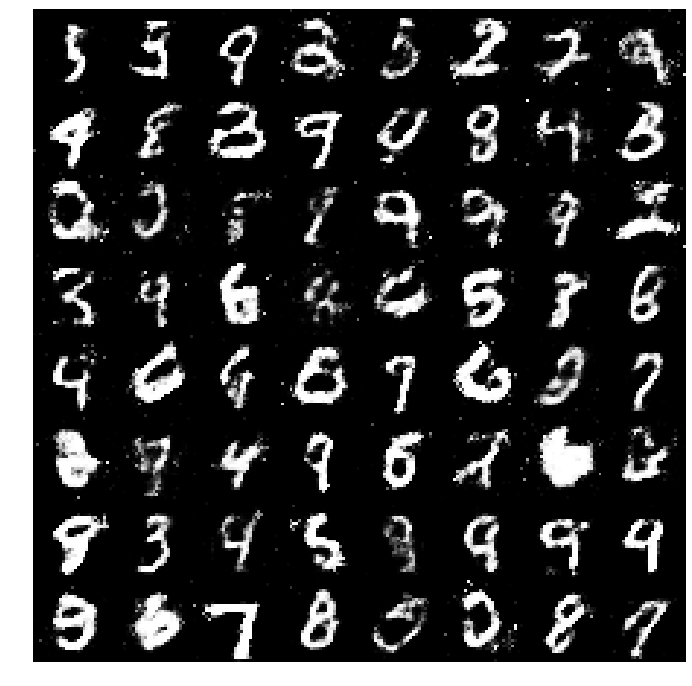

[Epoch 145/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 146/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 147/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 148/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 149/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


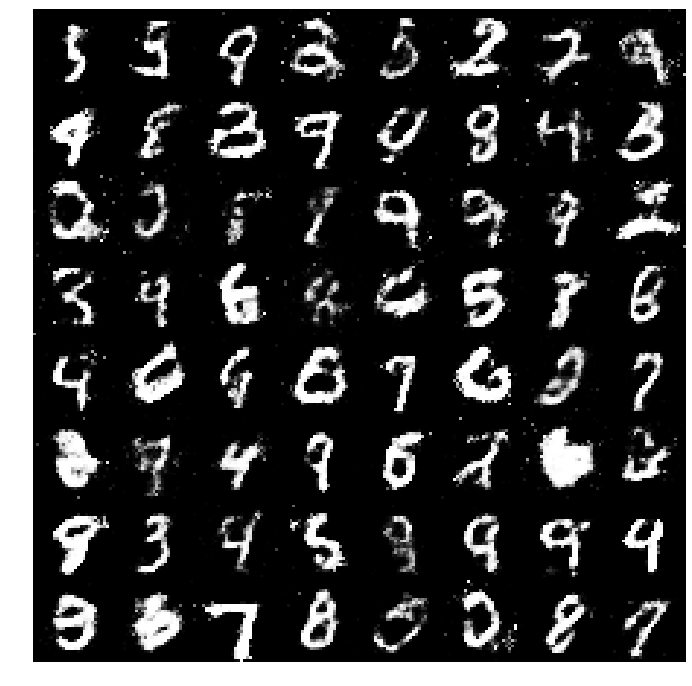

[Epoch 150/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 151/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 152/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 153/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 154/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


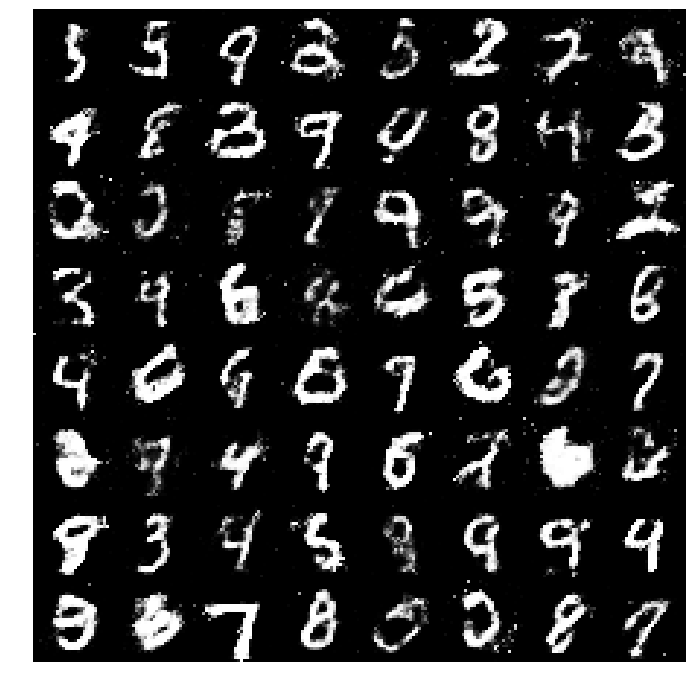

[Epoch 155/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 156/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 157/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 158/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 159/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


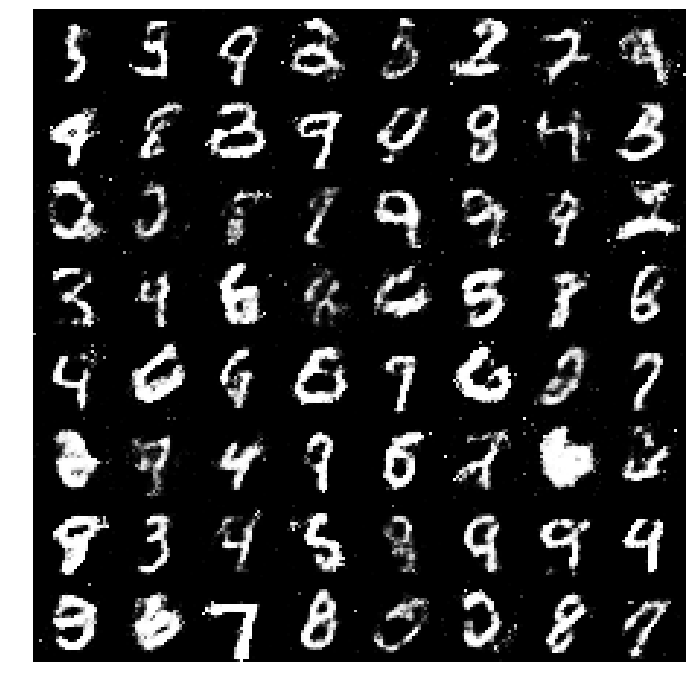

[Epoch 160/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 161/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 162/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 163/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 164/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


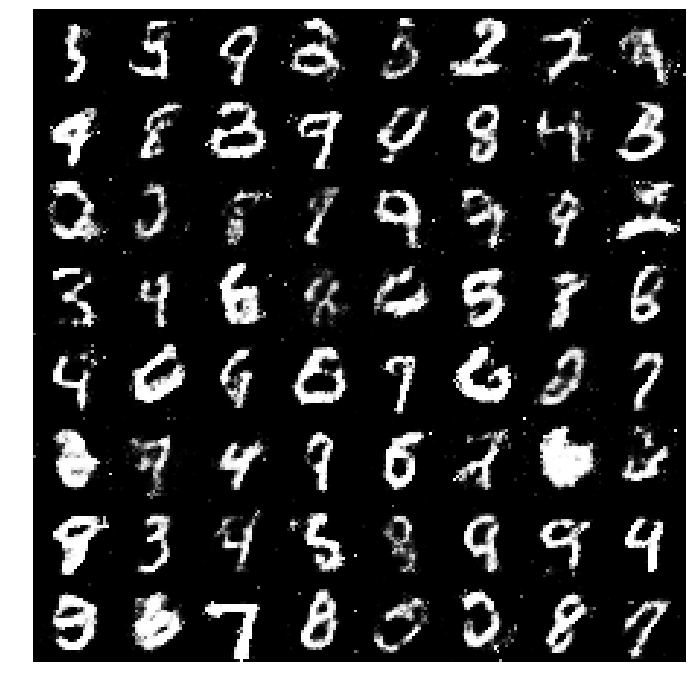

[Epoch 165/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 166/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 167/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 168/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 169/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


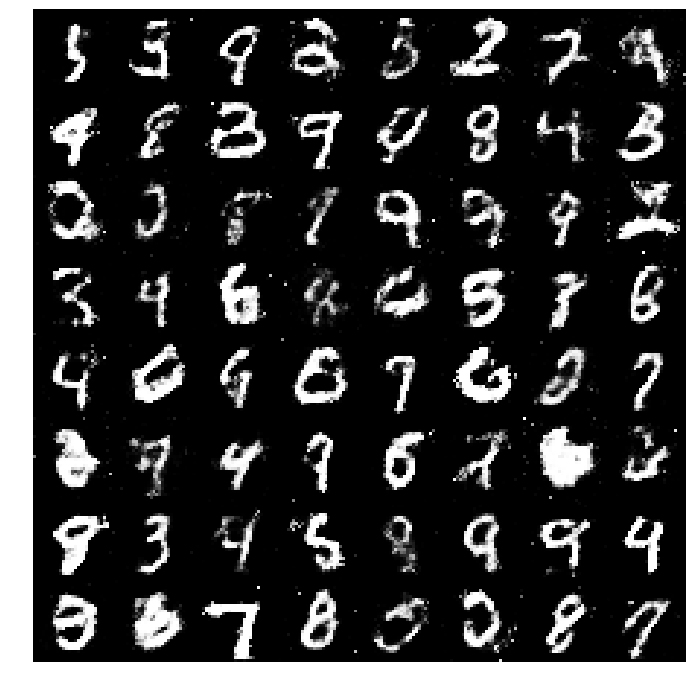

[Epoch 170/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 171/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 172/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 173/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 174/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


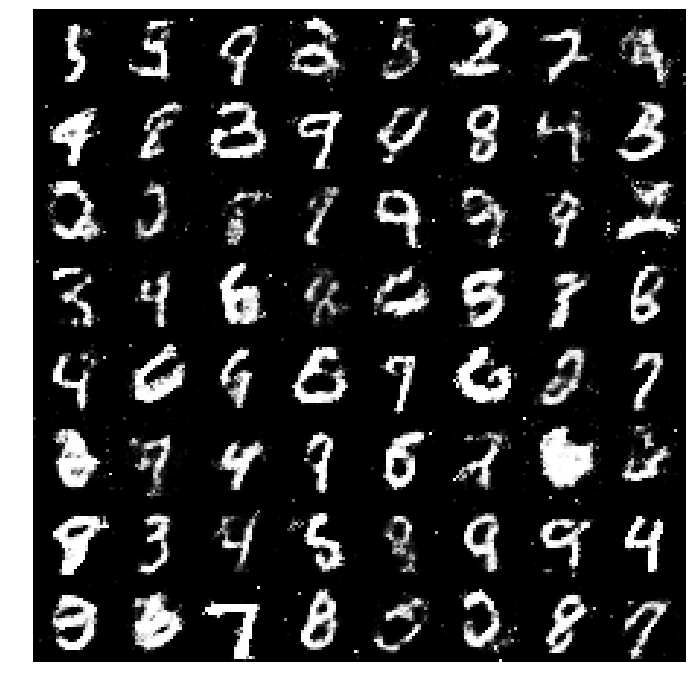

[Epoch 175/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 176/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 177/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 178/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 179/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


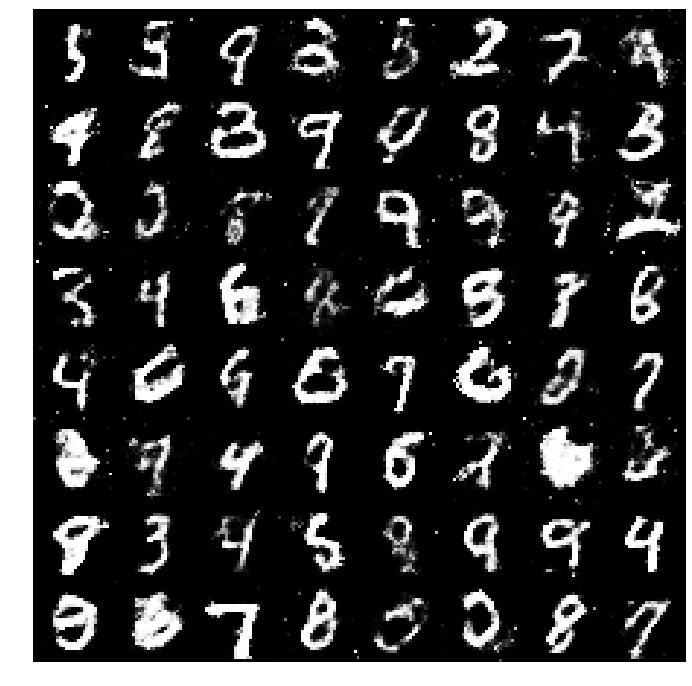

[Epoch 180/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 181/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 182/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 183/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 184/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


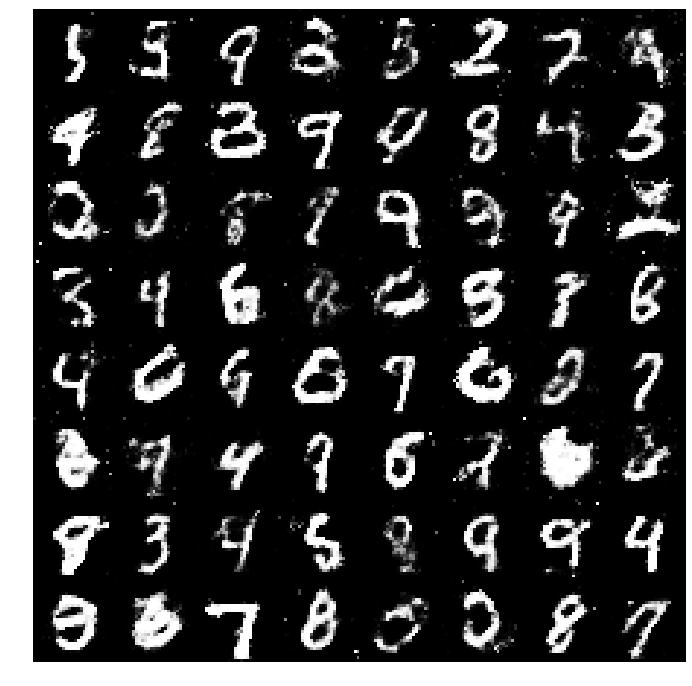

[Epoch 185/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 186/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 187/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 188/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 189/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


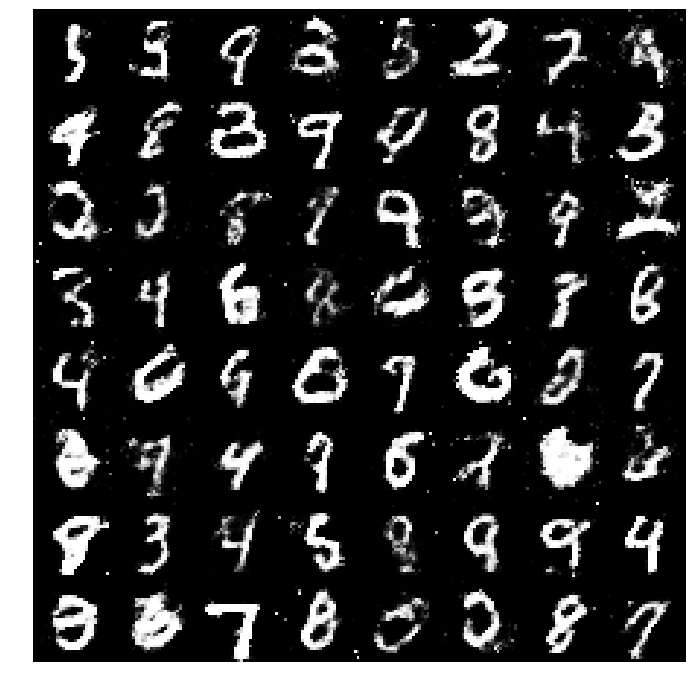

[Epoch 190/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 191/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 192/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 193/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 194/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


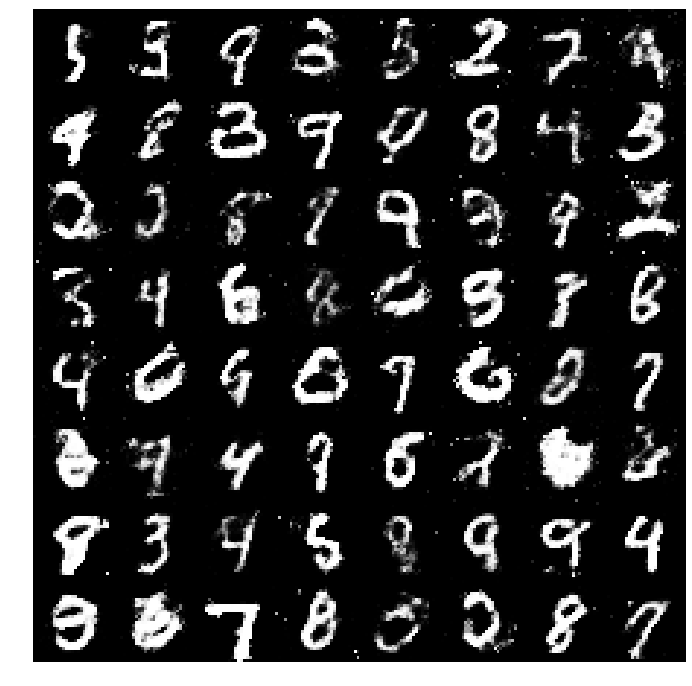

[Epoch 195/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 196/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 197/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 198/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 199/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


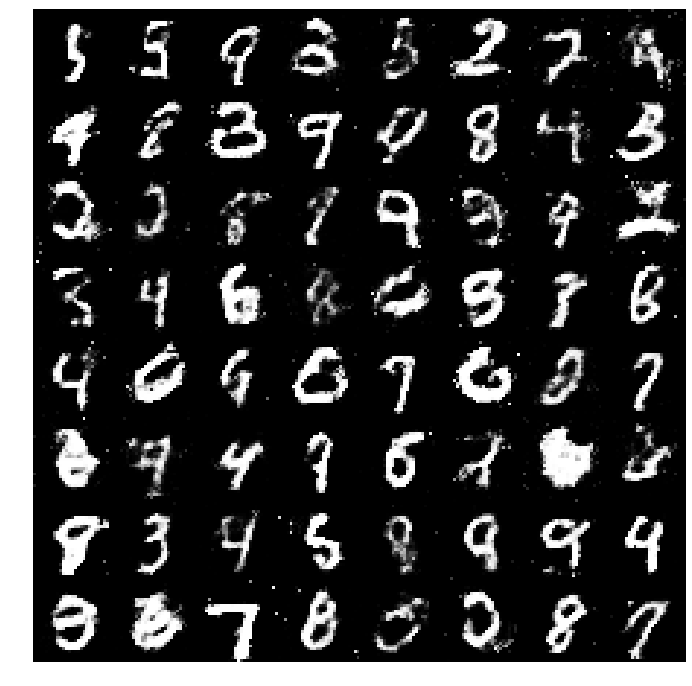

[Epoch 200/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 201/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 202/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 203/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 204/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


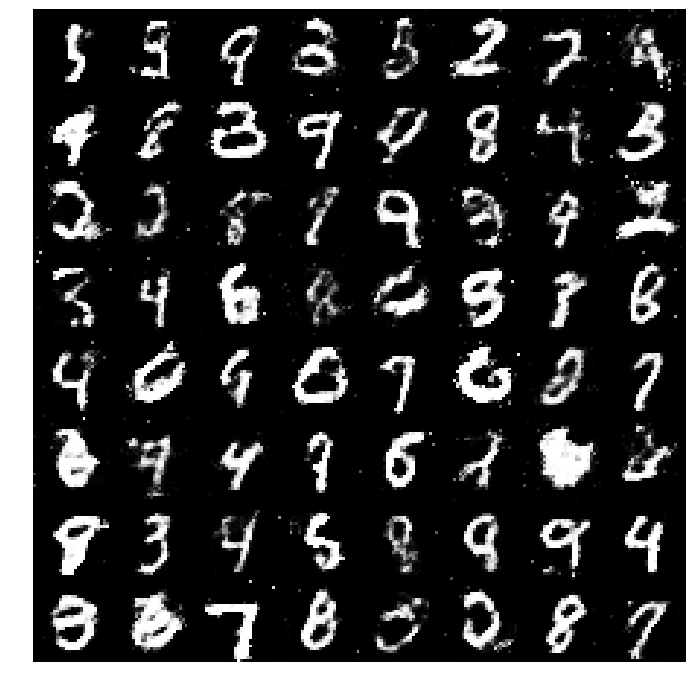

[Epoch 205/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 206/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 207/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 208/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 209/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


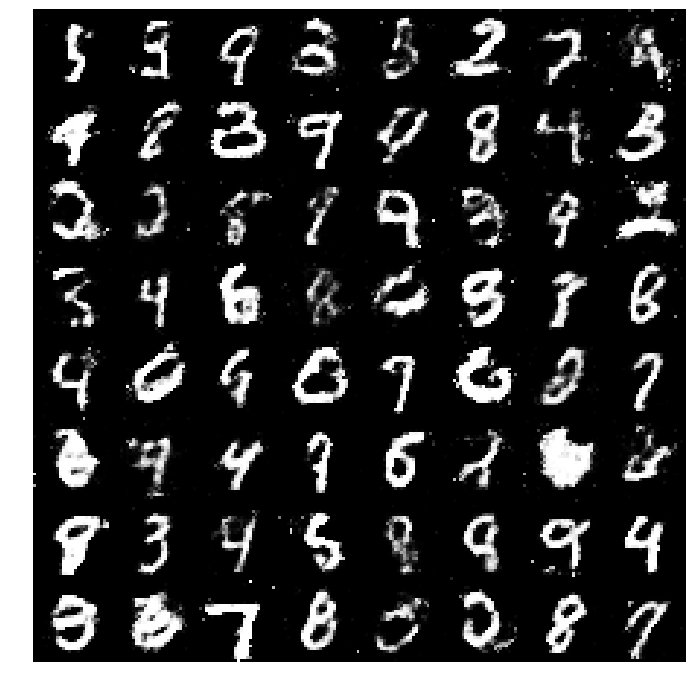

[Epoch 210/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 211/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 212/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 213/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 214/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


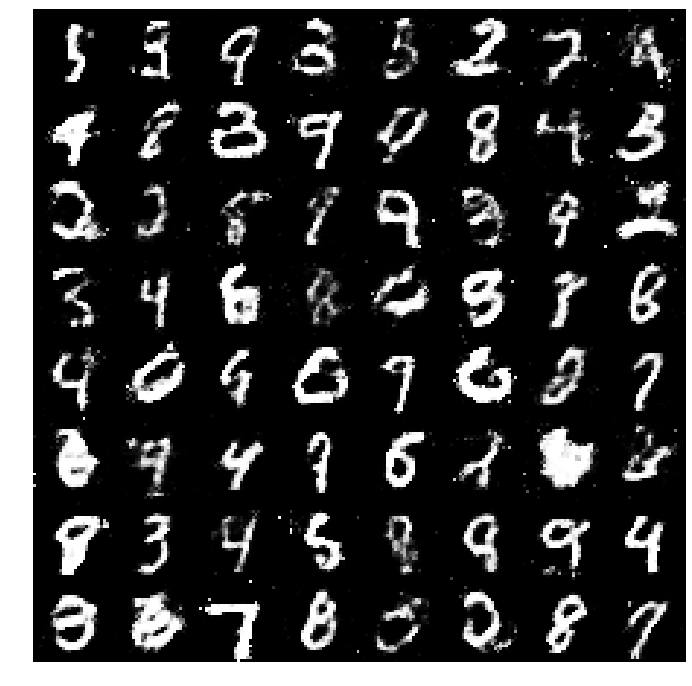

[Epoch 215/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 216/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 217/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 218/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 219/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


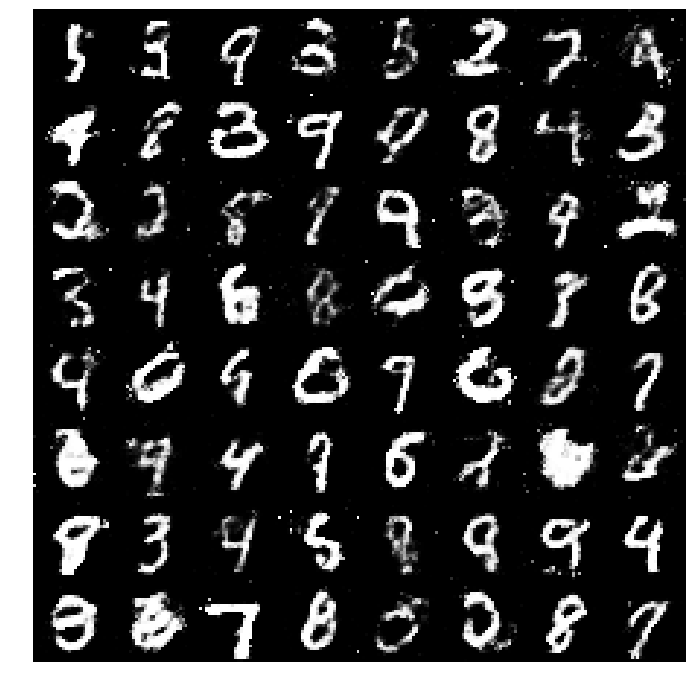

[Epoch 220/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 221/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 222/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 223/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 224/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


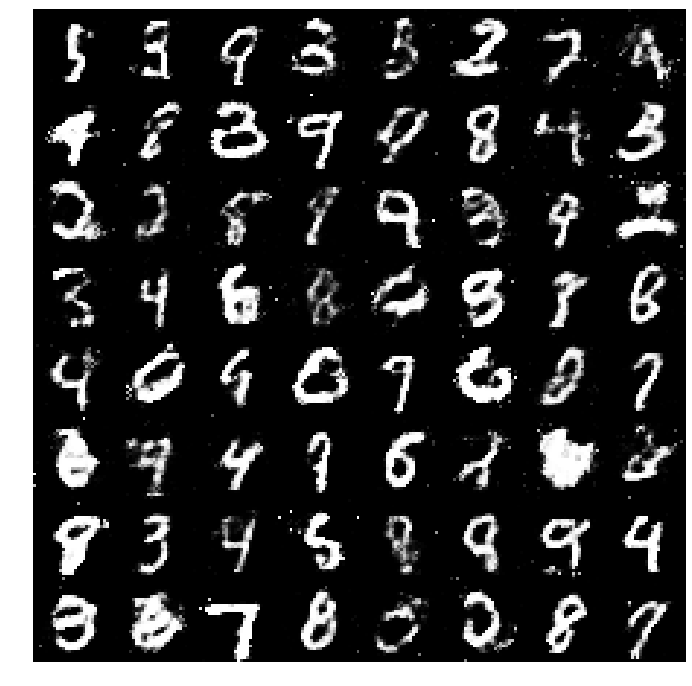

[Epoch 225/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 226/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 227/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 228/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 229/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


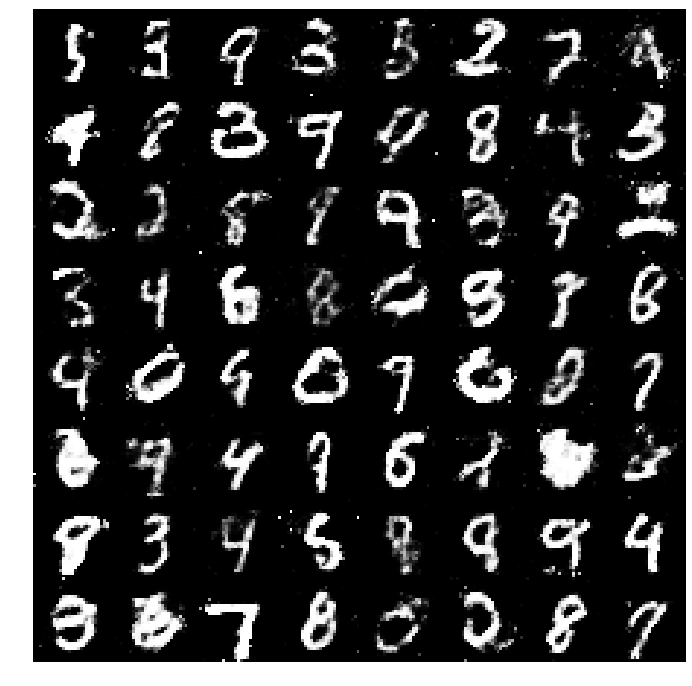

[Epoch 230/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 231/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 232/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 233/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 234/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


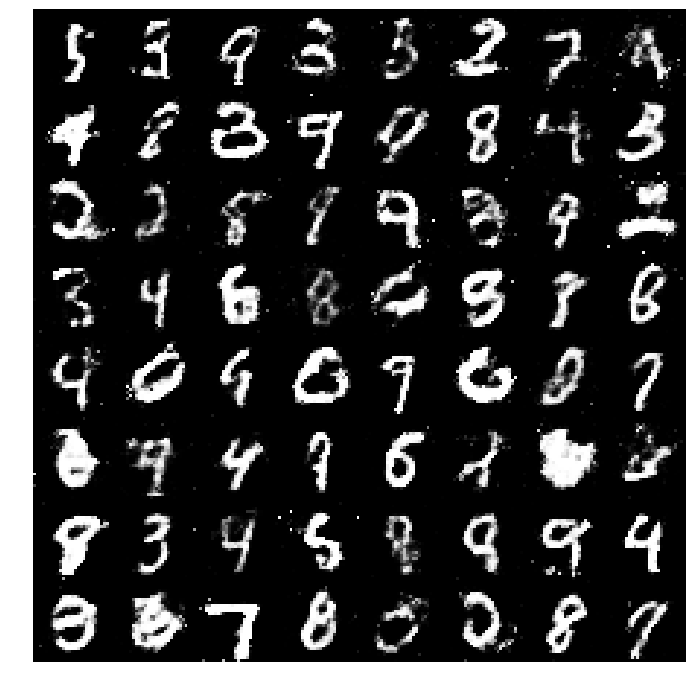

[Epoch 235/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 236/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 237/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 238/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 239/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


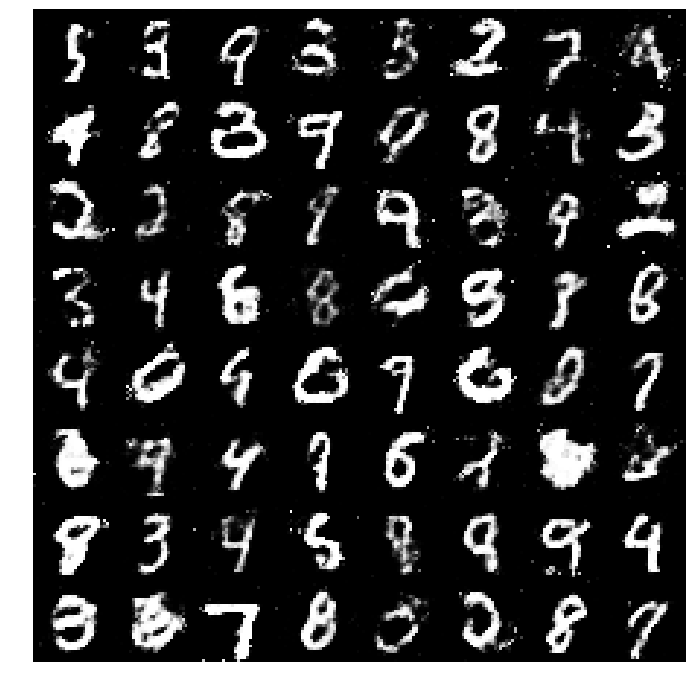

[Epoch 240/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 241/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 242/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 243/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 244/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


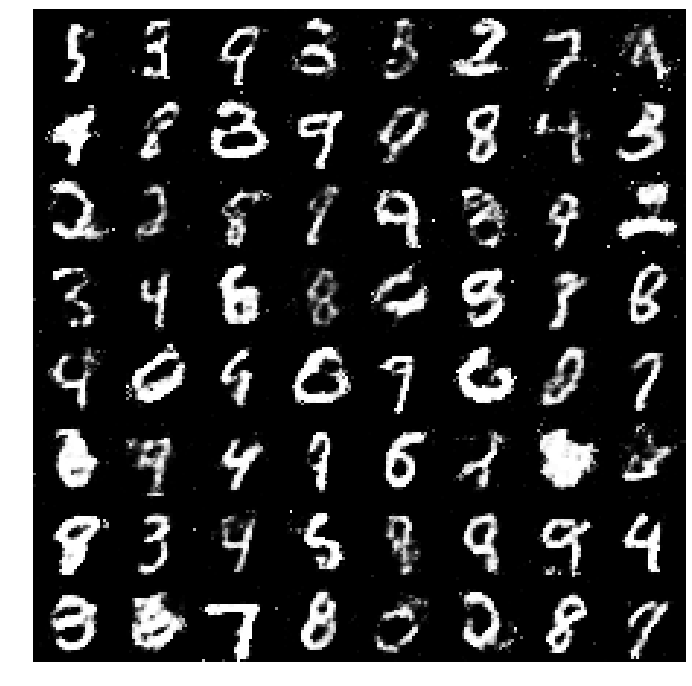

[Epoch 245/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 246/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 247/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 248/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 249/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


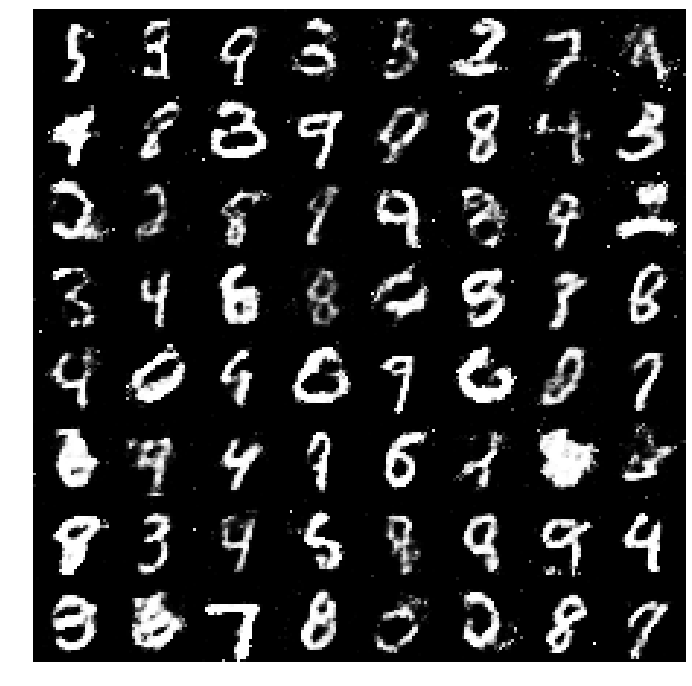

[Epoch 250/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 251/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 252/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 253/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 254/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


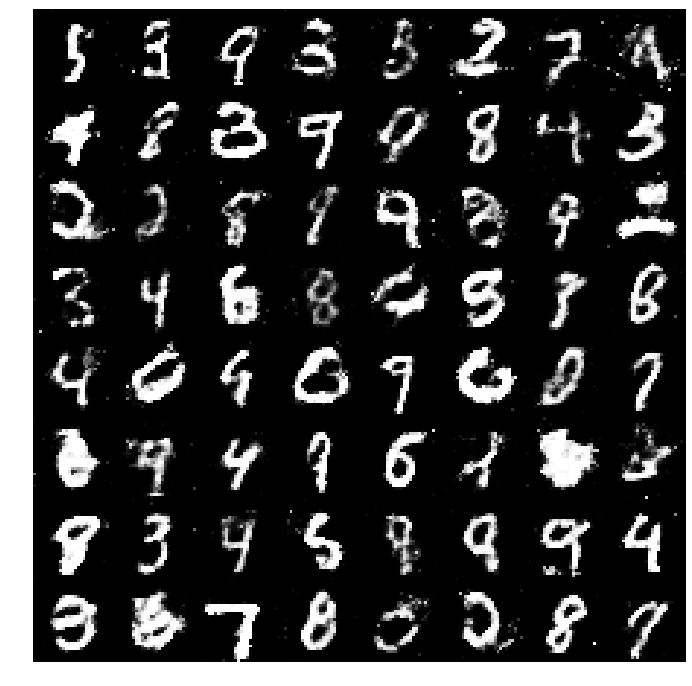

[Epoch 255/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 256/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 257/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 258/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 259/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


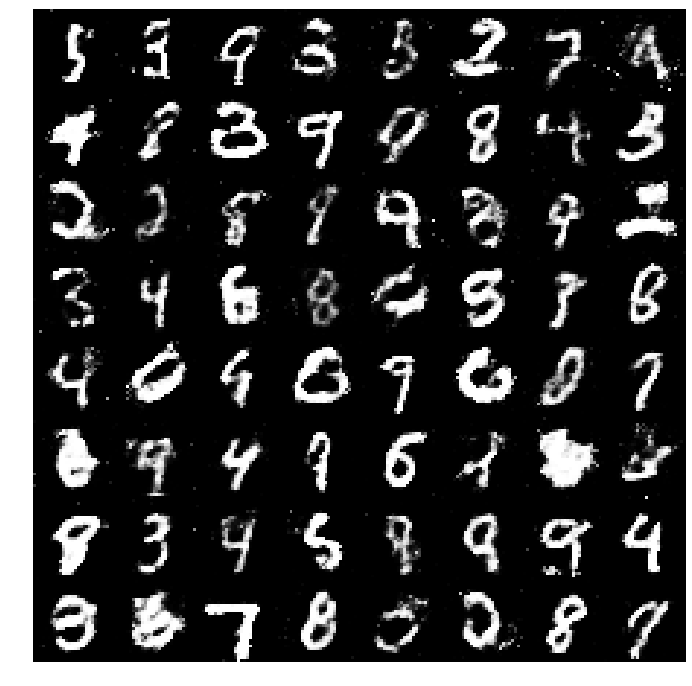

[Epoch 260/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 261/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 262/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 263/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 264/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


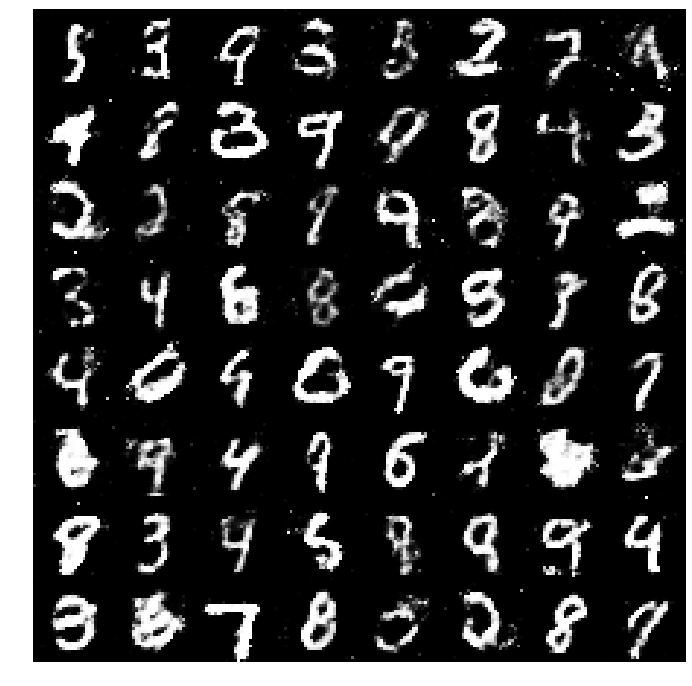

[Epoch 265/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 266/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 267/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 268/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 269/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


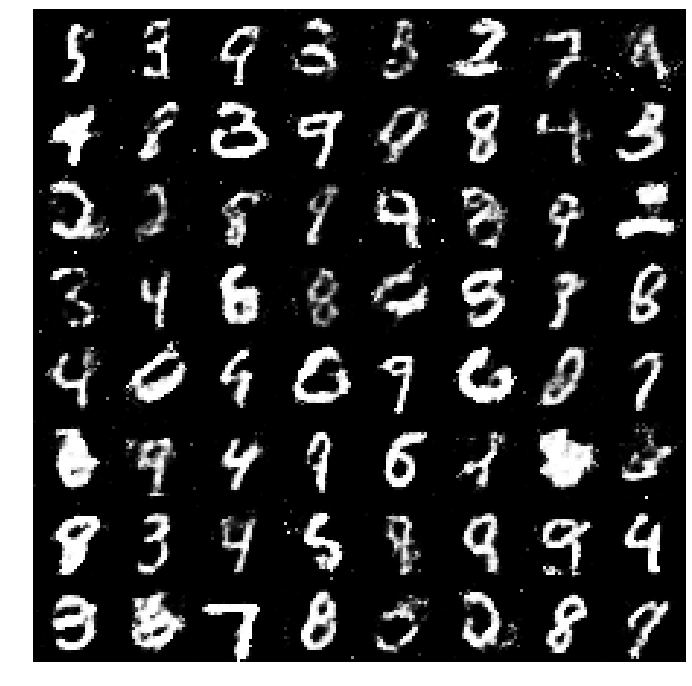

[Epoch 270/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 271/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 272/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 273/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 274/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


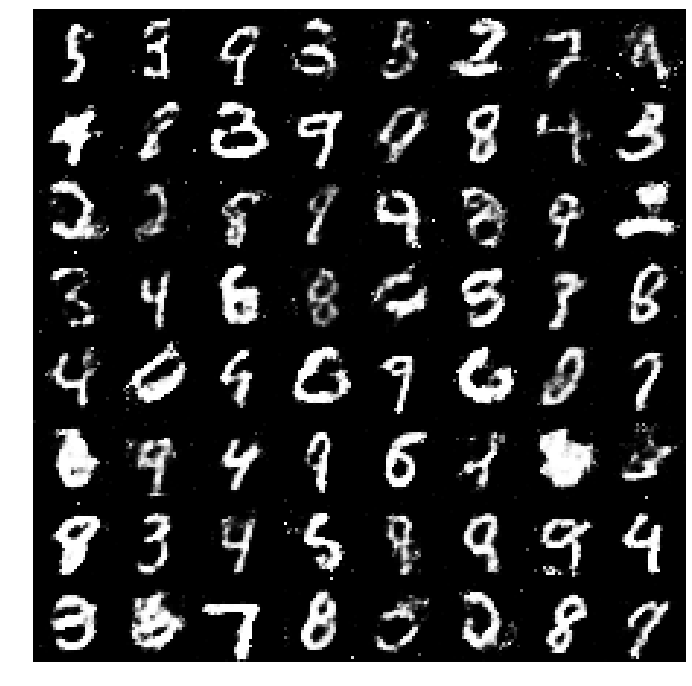

[Epoch 275/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 276/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 277/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 278/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 279/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


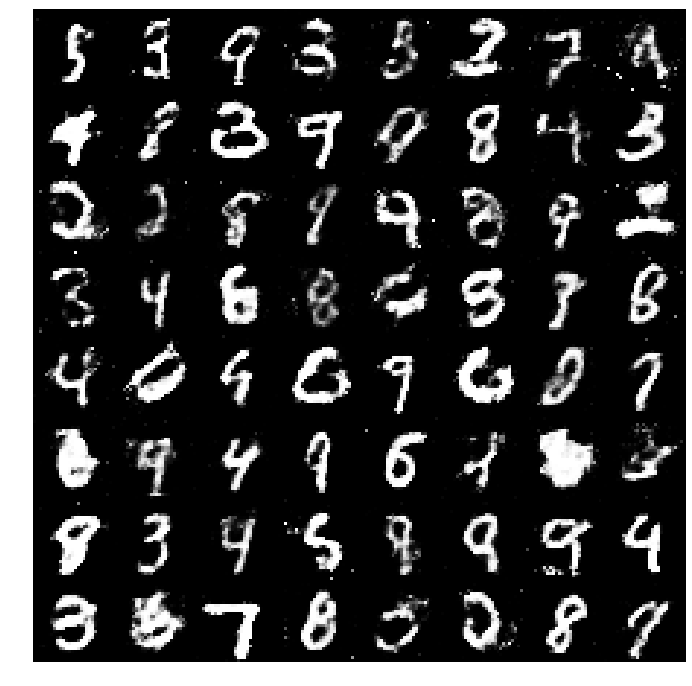

[Epoch 280/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 281/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 282/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 283/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 284/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


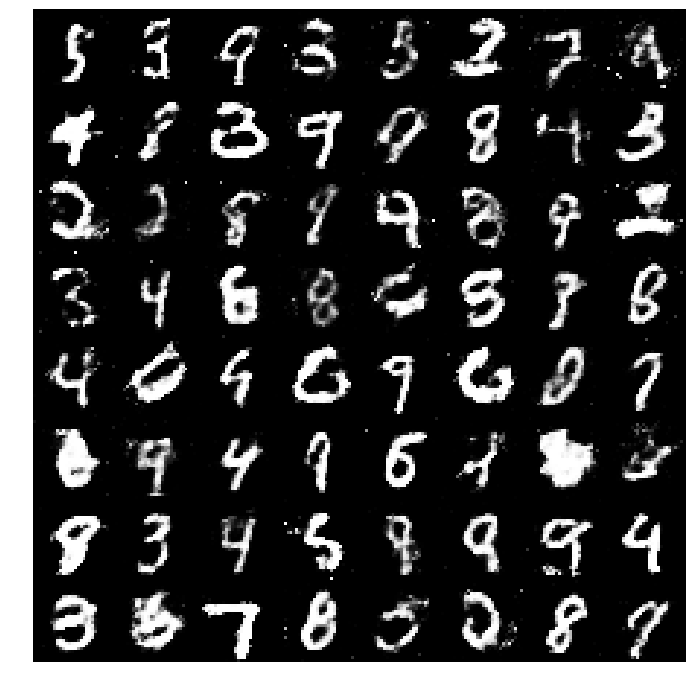

[Epoch 285/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 286/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 287/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 288/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 289/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


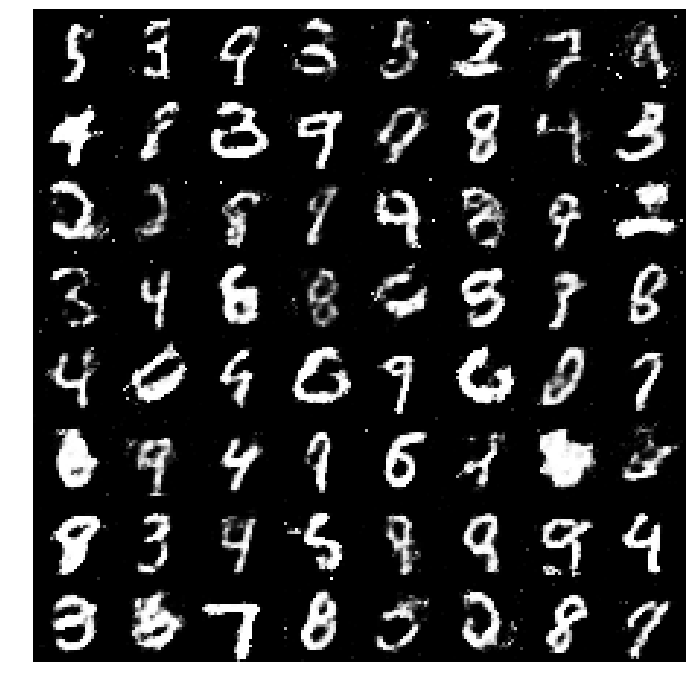

[Epoch 290/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 291/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 292/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 293/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 294/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


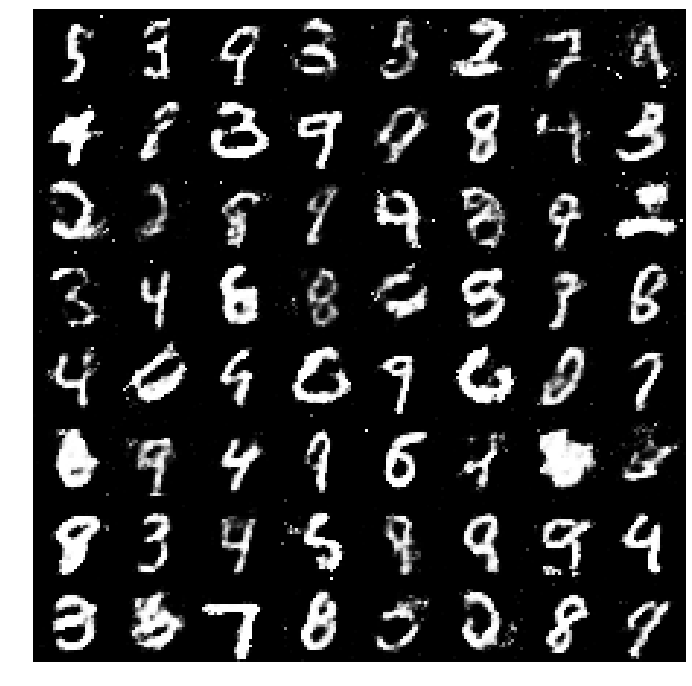

[Epoch 295/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 296/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 297/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 298/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300
[Epoch 299/300] -- Saved ./checkpoints/vanilla_NO_BN_d_lr0.0002_g_lr0.0002_0.5_1_300


In [9]:
with tf.Graph().as_default() as graph:
    z = tf.placeholder(tf.float32, shape=[None, Z_DIM])
    z_fixed = tf.placeholder(tf.float32, shape=[None, Z_DIM])

    x = tf.placeholder(tf.float32, shape=[None, HEIGHT * WIDTH])
    
    g = generator(z, g_layers, training=True, reuse=False)
    g_fixed = generator(z_fixed, g_layers, training=False, reuse=True)
    real_logits = discriminator(x, d_layers, training=True, reuse=False)
    fake_logits = discriminator(g, d_layers, training=True, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_logits, 
                                                                         labels=tf.ones_like(real_logits)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, 
                                                                         labels=tf.zeros_like(fake_logits)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, 
                                                                    labels=tf.ones_like(fake_logits)))
    
    d_loss = d_loss_real + d_loss_fake
    
    d_loss_real_summary = tf.summary.scalar("d_loss_real", d_loss_real)
    d_loss_fake_summary = tf.summary.scalar("d_loss_fake", d_loss_fake)
    g_loss_summary = tf.summary.scalar("g_loss", g_loss)
    d_loss_summary = tf.summary.scalar("d_loss", d_loss)
    images_summary = tf.summary.image("generated_images", tf.reshape((g_fixed + 1.) / 2., [BATCH_SIZE, HEIGHT, WIDTH, 1]))
    
    trainable_vars = tf.trainable_variables()
    d_vars = [var for var in trainable_vars if 'discriminator' in var.name]
    g_vars = [var for var in trainable_vars if 'generator' in var.name]
    
    print(d_vars)
    print(g_vars)
    
    d_optim = tf.train.AdamOptimizer(D_LEARNING_RATE, beta1=BETA1)\
                    .minimize(d_loss, var_list=d_vars)
    g_optim = tf.train.AdamOptimizer(G_LEARNING_RATE, beta1=BETA1)\
                    .minimize(g_loss, var_list=g_vars)
    
    d_summary = tf.summary.merge([d_loss_real_summary, d_loss_fake_summary, d_loss_summary])
    g_summary = tf.summary.merge([g_loss_summary, images_summary])
    
with tf.Session(graph=graph) as sess:
    saver = tf.train.Saver()
    writer = tf.summary.FileWriter("./runs/{}".format(RUN_NAME), sess.graph)
    summary_step = 0
    
    if SAVE_PATH:
        saver.restore(sess, SAVE_PATH)
    else:
        init = tf.global_variables_initializer()
        sess.run(init)
    
    z_fixed_input = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM])

    for epoch in range(N_EPOCHS):
        np.random.shuffle(image_list)
        i = 0
        while i < len(image_list):
            x_input = np.zeros([BATCH_SIZE, HEIGHT, WIDTH, CHANNELS])
            for k in range(0, BATCH_SIZE):
                x_input[k] = cv2.imread(
                                os.path.join(image_dir, image_list[i + k])
                                )[:, :, [0]]
            
            x_input = transform(x_input / 255).reshape(BATCH_SIZE, -1)
            z_input = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM])
            
            [_, d_summary_result, d_loss_val, dlrv, dlfv] = sess.run([d_optim, d_summary, d_loss, d_loss_real, d_loss_fake], feed_dict={z: z_input, x: x_input})
            
            for _ in range(G_ITERS):
                [_, g_img, g_summary_result] = sess.run([g_optim, g_fixed, g_summary], feed_dict={z: z_input,
                                                                                                   z_fixed: z_fixed_input,
                                                                                                   x: x_input})                
            if (i % (BATCH_SIZE * 50) == 0):
                writer.add_summary(g_summary_result, summary_step)
                writer.add_summary(d_summary_result, summary_step)
                summary_step += 1
            
            i += BATCH_SIZE
            
        if epoch % 5 == 0:
            plot_images(inverse_transform(g_img.reshape(BATCH_SIZE, HEIGHT, WIDTH)))
            cv2.imwrite(f'./results/{epoch}.jpg', make_grid(inverse_transform(g_img.reshape(BATCH_SIZE, HEIGHT, WIDTH))))

        save_path = saver.save(sess, "./checkpoints/{}".format(RUN_NAME))
        print(f"[Epoch {epoch}/{N_EPOCHS}] -- Saved {save_path}")


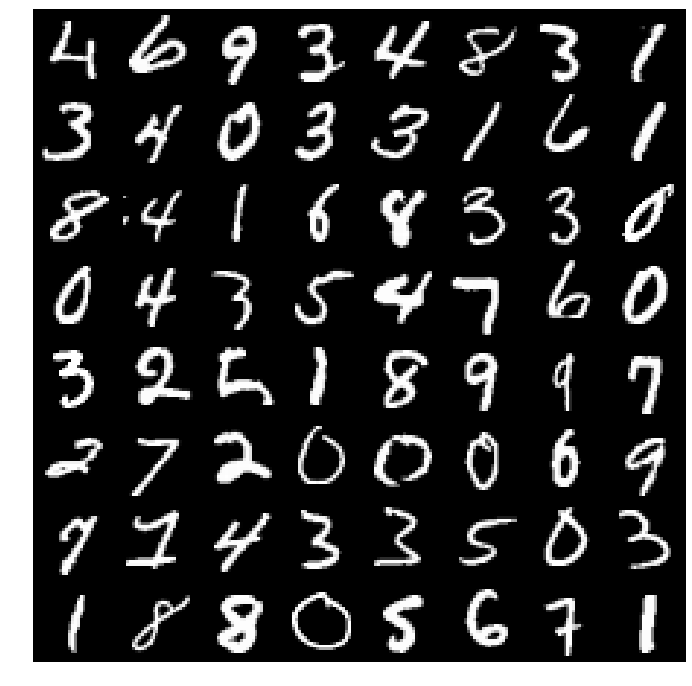

In [11]:
plot_images(x_input.reshape(BATCH_SIZE, HEIGHT, WIDTH))